In [23]:
# %pip install -U pip datasets ipywidgets
# For mac OS
# %pip install -U tensorflow==2.16.2 tensorflow-macos==2.16.2 keras==3.4.1 keras-nlp
# 20240803, tensorflow-text can be installed on Apple Silicon mac now!
# %pip install tensorflow-text
# For Intel mac
# %pip install -U tensorflow==2.16.2 tensorflow-text keras==3.4.1 keras-nlp
# For AWS SageMaker
# %pip install -U tensorflow==2.16.2 tensorflow-datasets tensorflow-text keras==3.4.1 keras-nlp datasets rouge-score py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 754.8 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.1/236.1 MB 2.1 MB/s eta 0:00:0000:0100:03m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 1.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.2
    Uninstalling tensorflow-2.16.2:
      Successfully uninstalled tensorflow-2.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-macos 2.16.2 requires ten

In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
# Utility function to determine where this note is running
import platform

def is_running_on_apple_silicon():
    """
    Determine if this is running on Apple Silicon Mac.
    """
    return platform.system() == "Darwin" and platform.processor() == "arm"

def is_running_on_intel_mac():
    """
    Determine if this is running on Intel Mac.
    """
    return platform.system() == "Darwin" and platform.processor() == "i386"

# This flag is used for tf.debugging.experimental.enable_dump_debug_info.
# However, this makes 10 times slower.
DEBUGGER_V2 = False

In [3]:
import tensorflow as tf
import keras
import keras_nlp
print("Tensorflow 2.17.0 is expected. The running version is", tf.__version__)
print("Keras 3.4.1 is expected. The running version is", keras.__version__)
print("KerasNLP 0.12.1 is expected. The running version is", keras_nlp.__version__)

if is_running_on_apple_silicon() or is_running_on_intel_mac():
    FLOAT_TYPE = tf.float32
else:
    """
    # Mixed-precision training
    Deep Learning with Python, Second Edition
    François Chollet

    However, this makes the processing 2.x slower on M2 Apple Silicon.

    Machine | 1 step
    --- | ---
    Intel Mac - fp32 : fp16 | 1 : 1.714
    Apple Silicon M2 (Mac Book Pro) - fp32 : fp16 | 1 : 2.813
    NVIDIA V100 GPU x 1 (ml.p3.2xlarge) - fp32 : fp16 | 1 : 0.875    Intel Mac - fp32 : fp16 | 1 : 1.714
    """
    keras.mixed_precision.set_global_policy("mixed_float16")
    FLOAT_TYPE = tf.float16

import numpy as np
import tensorflow_datasets as tfds
# SageMaker cannot use @keras.saving
from keras import saving
import datetime

Tensorflow 2.16.2 is expected. The running version is 2.17.0
Keras 3.4.1 is expected. The running version is 3.4.1
KerasNLP 0.12.1 is expected. The running version is 0.12.1


# Utility function

In [4]:
import matplotlib.pyplot as plt

def plot(history, title=None, keys=["loss", "masked_acc"]):
    """
    Display the plot that indicates the loss and accuracy.
    :param history: history object from the tensorflow fit function.
    :param title: title text.
    :param keys: keys for plotting.
    """
    for key in keys:
        if 'loss' in key:
            print(
                np.min(history.history[f"val_{key}"]),
                "The best number of epocs for the validation loss is",
                np.argmin(history.history[f"val_{key}"]) + 1,
            )
        else:
            print(
                np.max(history.history[f"val_{key}"]),
                "The best number of epocs for the validation accuracy is",
                np.argmax(history.history[f"val_{key}"]) + 1,
            )

    flg, axes = plt.subplots(1, 2, tight_layout=True)
    if title is not None:
        flg.suptitle(t=title, fontsize=14)
    for i, key in enumerate(keys):
        value = history.history[key]
        val_loss = history.history[f"val_{key}"]
        epochs = range(1, len(value) + 1)
        axes[i].plot(epochs, value, label=f"Training {key}")
        axes[i].plot(epochs, val_loss, label=f"Validation {key}")
        axes[i].set_title(f"Training and validation {key}")
        axes[i].set_xlabel("epochs")
        axes[i].set_ylabel(key)
        axes[i].legend()
    plt.show()


In [6]:
def get_log_dir(now):
    log_dir = "logs/fit/" + now.strftime("%Y%m%d-%H%M%S")
    return log_dir

def get_tensorboard_callback(now):
    """
    Create the TensorBoard callback
    """
    # @see https://www.tensorflow.org/tensorboard/get_started
    log_dir = get_log_dir(now=now)
    tensorboard_callback = keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    )
    return tensorboard_callback

In [8]:
# @see https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduce_lr_callbacks = keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_delta=0.04,
    cooldown=8,
    min_lr=2e-5, # 5e-4: 0.0005, 2e-5: 0.00002
)

In [9]:
"""
### The reason why the masked loss is required for seq2seq models

The prediction y values of seq2seq models contain pad(s), which are used to align the length of every output sequence.
In the case that most sequences are much shorter than the longest sentence and pads are not considered,
a model that predicts only pads of sentences is highly evaluated.
Therefore, excluding pads from the loss calculation improves the model.

### The reason why the classification model does not use the masked loss function

The prediction y values of classification models do not contain pad(s), which are used to align the length of every output sequence.
It just contains the probability of each class.
"""

# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
@saving.register_keras_serializable()
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        # nn.py:609: UserWarning:
        # "`sparse_categorical_crossentropy` received `from_logits=True`,
        # but the `output` argument was produced by a Softmax activation and thus does not represent logits.
        # Was this intended?
        # When logits is True, softmax activation function has not processed the values.
        from_logits=True,
        reduction='none'
    )
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, dtype=loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [10]:
# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
# @saving.register_keras_serializable()
# def masked_acc(y_true, y_pred):
#     # Calculate the loss for each item in the batch.
#     y_pred = tf.argmax(y_pred, axis=-1) # last index
#     y_pred = tf.cast(y_pred, dtype=y_true.dtype)
#     match = tf.cast(y_true == y_pred, dtype=FLOAT_TYPE)
#     mask = tf.cast(y_true != 0, dtype=FLOAT_TYPE)
#     return tf.reduce_sum(match)/tf.reduce_sum(mask)

# @see https://www.tensorflow.org/text/tutorials/transformer
@saving.register_keras_serializable()
def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=2)
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    match = y_true == y_pred
    mask = y_true != 0
    match = match & mask
    match = tf.cast(match, dtype=FLOAT_TYPE)
    mask = tf.cast(mask, dtype=FLOAT_TYPE)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

## Dataset

In [11]:
import datasets

def prepare_datasets():
    """
    Get training set, validation set, and test set
    tensorflow_datasets does not work well with the SSL error.
    Therefore, the data is obtained with the Huggingface library and converted to Tensorflow.
    :return: train_ds
    :return: validation_ds
    :return: test_ds
    """
    # How to convert huggingface dataset to tensorflow dataset
    # @see https://huggingface.co/docs/datasets/v1.3.0/torch_tensorflow.html#setting-the-format
    def convert_hf2tf(
            dataset: datasets.DatasetDict,
            split: list[str],
            columns=['article', 'highlights', 'id',]):
        dataset.set_format(
            type='tensorflow',
            columns=columns
        )
        l = []
        for s in split:
            d = dataset[s]
            features = {x: d[x] for x in columns}
            # .batch(32) is not used to show a simple sampled data below with take(1)
            tf_dataset = tf.data.Dataset.from_tensor_slices(features)
            l.append(tf_dataset)
        return tuple(l)
    ds = datasets.load_dataset(
        'Samsung/samsum',
        trust_remote_code=True
    )
    train_ds, validation_ds, test_ds = convert_hf2tf(
        dataset=ds,
        split=['train', 'validation', 'test'],
        columns=['id', 'summary', 'dialogue'],
    )
    return train_ds, validation_ds, test_ds

# Prediction

In [12]:
def generate_text(
        model,
        input_text,
        max_length=64):
    """
    Generate summarized text
    :model: the trained BART model
    :input_text: the original text that is summarized
    :max_length: the length of the summarized text
    """
    output = model.generate(
        input_text,
        max_length=max_length
    )
    return output

def generate_prediction_result(
        bart_lm,
        ds,
        max_length=64):
    """
    Generate summarized text from the dataset
    :bart_lm: the trained BART model
    :ds: the dataset, which is mainly text set, that is summarized
    :max_length: the length of the summarized text
    """
    x = []
    y_true = []
    for row in ds:
        x.append(row["encoder_text"].numpy())
        y_true.append(row["decoder_text"].numpy())

    # The first call to XLA generally takes a bit longer
    # because the XLA contains overhead of compilation and optimization.
    _ = generate_text(
        bart_lm,
        "dummy",
        max_length=max_length
    )

    y_pred = generate_text(
        bart_lm,
        ds.map(lambda row: row["encoder_text"]).batch(8),
        max_length=max_length,
    )
    return x, y_true, y_pred

def display_sampled_summary(
        x,
        y_true,
        y_pred,
        sample=5):
    """
    Line up the actual summarized text.
    :x: the original text that is summarized
    :y_true: the ground truth value
    :y_pred: the generated summarized text
    :sample: the number of set to display
    """
    for i in range(sample):
        print("text:", x[i])
        print("y_true:", y_true[i])
        print("y_pred:", y_pred[i])

def calculate_rouge_score(y_true, y_pred):
    """
    Calculate the ROUGE scores
    :y_true: the ground truth value
    :y_pred: the generated summarized text
    :returns: ROUGE-1 score
    :returns: ROUGE-2 score
    :returns: ROUGE-L score
    """
    rouge_n = keras_nlp.metrics.RougeN(order=2)
    rouge_2_score = rouge_n(y_true, y_pred)
    rouge_n = keras_nlp.metrics.RougeN(order=1)
    rouge_1_score = rouge_n(y_true, y_pred)
    rouge_l = keras_nlp.metrics.RougeL()
    rouge_l_score = rouge_l(y_true, y_pred)
    return rouge_1_score, rouge_2_score, rouge_l_score

## Model and Training

In [13]:
class RougeEvaluator(keras.callbacks.Callback):
    """
    Callback to calculate ROUGE scores for every epoch
    """
    def __init__(
            self,
            dataset,
            max_length):
        """
        :dataset: dataset object that is used for ROUGE evaluation
        :max_length: the max length of the summarized text
        """
        self.dataset = dataset
        self.max_length = max_length
  
    def on_epoch_end(self, epoch, logs=None):
        _, y_true, y_pred = generate_prediction_result(
            bart_lm=self.model,
            ds=self.dataset,
            max_length=self.max_length
        )
        rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
            y_true=y_true,
            y_pred=y_pred
        )
        print(rouge_1_score)
        print(rouge_2_score)
        print(rouge_l_score)

def format_dataset_bart_seq2seq(row):
    return {
        "encoder_text": row["dialogue"],
        "decoder_text": row["summary"]
    }
    
def build_bart_model(
    training_data,
    validation_data,
    encoder_sequence_length=128,  # 128: 75% covered. max is 803.
    decoder_sequence_length=64,  # 32: 75% covered. max is 64
    learning_rate=5e-5,
    weight_decay=0.01,
    epsilon=1e-6,
    global_clipnorm=1.0,
    batch_size=8,
    epochs=5,
    preset_name="bart_base_en",
    verbose=1,
    is_saved=False):
    """
    Build the BART model with specified parameters.
    :return: model: trained BART model
    :return: filepath: model file path if it is saved
    :return: history: history object to plot
    """
    now = datetime.datetime.now()
    preprocessor = keras_nlp.models.BartSeq2SeqLMPreprocessor.from_preset(
        preset_name,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
    )
    bart_lm = keras_nlp.models.BartSeq2SeqLM.from_preset(
        preset_name,
        preprocessor=preprocessor
    )
    callbacks = []
    # if verbose > 0:
    #     bart_lm.summary()
    #     if validation_data is not None and not is_running_on_apple_silicon():
    #         callbacks.append(RougeEvaluator(
    #             dataset=validation_data.map(format_dataset_bart_seq2seq),
    #             max_length=decoder_sequence_length,
    #         ))

    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        epsilon=epsilon,
        global_clipnorm=global_clipnorm,
    )

    # Exclude layernorm terms and bias terms from weight decay.
    optimizer.exclude_from_weight_decay(var_names=[
        "bias",
        "gamma",
        "beta",
    ])

    bart_lm.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        weighted_metrics=[
            "accuracy"
        ],
    )
    val_ds = None
    if validation_data is not None:
        val_ds = validation_data.map(format_dataset_bart_seq2seq).batch(batch_size).cache()
    callbacks.append(get_tensorboard_callback(now=now))
    history = bart_lm.fit(
        training_data.map(format_dataset_bart_seq2seq).batch(batch_size).cache(),
        validation_data=val_ds,
        epochs=epochs,
        verbose=verbose,
        callbacks=callbacks,
    )

    filepath = None
    if is_saved:
        timestamp = now.strftime('%Y-%m-%d_%H-%M-%S')
        if is_running_on_apple_silicon() or is_running_on_intel_mac():
            filepath = f'model/summarization_model_{timestamp}.keras'
        else:
            filepath = f'summarization_model_{timestamp}.keras'
        print(f"Saving to {filepath}")
        bart_lm.save(filepath=filepath)
        print(f"Successfully saved model to {filepath}")

    return bart_lm, filepath, history

***

# Build

In [14]:
train_ds, validation_ds, test_ds = prepare_datasets()

2024-08-08 17:25:47.596630: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-08-08 17:25:47.596653: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-08-08 17:25:47.596656: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-08-08 17:25:47.596666: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-08 17:25:47.596680: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Note (Experiment Date: 2024-08-09 00:00:00~)

- Batch size comparison

#### Result

batch size | validation loss | validation accuracy | ROUGE-1 | ROUGE-2 | ROUGE-L
--- | --- | --- | --- | --- | ---
8 | **0.689** | **0.596** | **43.8** | **18.4** | **35.2**
16 | 0.693 | 0.591 | 43.3 | 17.9 | 34.6
32 | 0.698 | 0.589 | 43.5 | 17.9 | 34.2
64 | 0.695 | 0.591 | - (OOM) | - (OOM) | - (OOM)

The best batch size is 8. When the batch size was 64, the Out Of Memory (OOM) error happened and the experiment could not be completed.

In [ ]:
for batch_size in [8, 16, 32, 64]:
    bart_lm, filepath, history = build_bart_model(
        training_data=train_ds,
        validation_data=validation_ds,
        learning_rate=5e-6,
        batch_size=batch_size,
        epochs=20,
        preset_name="bart_large_en_cnn",
        is_saved=False,
    )
    plot(history=history, keys=["loss", "accuracy"])

    best_epoch = max(
        np.argmin(history.history[f"val_loss"]),
        np.argmax(history.history[f"val_accuracy"])
    )
    best_epoch = best_epoch + 1
    print("The best epoch is", best_epoch)
    bart_lm, filepath, _ = build_bart_model(
        training_data=train_ds.concatenate(validation_ds),
        validation_data=None,
        learning_rate=5e-6,
        batch_size=batch_size,
        epochs=best_epoch,
        preset_name="bart_large_en_cnn",
        verbose=0,
        is_saved=False,
    )
    dialogue, y_true, y_pred = generate_prediction_result(
        bart_lm=bart_lm,
        ds=test_ds.map(format_dataset_bart_seq2seq),
    )
    rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
        y_true=y_true,
        y_pred=y_pred
    )
    print(rouge_1_score)
    print(rouge_2_score)
    print(rouge_l_score)

### Note (Experiment Date: 2024-08-09 00:00:00~)

- Pre-trained model comparison

The experiments are devided to three because it caused the OOM error when they are executed in a for-loop.

#### Result

Pre-trained model | validation loss | validation accuracy | ROUGE-1 | ROUGE-2 | ROUGE-L
--- | --- | --- | --- | --- | ---
bart_base_en | 0.7504980564117432 | 0.5904136300086975 | 41.65521 | 17.03037 | 33.073547
bart_large_en | 0.743770956993103 | 0.5882247686386108 | 43.809313 | **19.138442** | **35.18229**
bart_large_en_cnn | **0.6905627250671387** | **0.5938532948493958** | **44.075152** | 18.462116 | 35.14399

#### Next


In [ ]:
for preset_name in ['bart_base_en', 'bart_large_en_cnn', ]: # 'bart_large_en', 
    bart_lm, filepath, history = build_bart_model(
        training_data=train_ds,
        validation_data=validation_ds,
        learning_rate=5e-6,
        epochs=20,
        preset_name=preset_name,
        is_saved=False,
    )
    plot(history=history, keys=["loss", "accuracy"])

    best_epoch = max(
        np.argmin(history.history[f"val_loss"]),
        np.argmax(history.history[f"val_accuracy"])
    )
    best_epoch = best_epoch + 1
    print("The best epoch is", best_epoch)
    bart_lm, filepath, _ = build_bart_model(
        training_data=train_ds.concatenate(validation_ds),
        validation_data=None,
        learning_rate=5e-6,
        epochs=best_epoch,
        preset_name=preset_name,
        verbose=0,
        is_saved=False,
    )
    dialogue, y_true, y_pred = generate_prediction_result(
        bart_lm=bart_lm,
        ds=test_ds.map(format_dataset_bart_seq2seq),
    )
    rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
        y_true=y_true,
        y_pred=y_pred
    )
    print(rouge_1_score)
    print(rouge_2_score)
    print(rouge_l_score)

### Note (Experiment Date: 2024-08-08 12:52:00~)

- Smaller learning rates

So far, the performances have not been improved through the training process. Too larger updates of the gradient possibly block the appropriate training. Therefore, the smaller learning rates, such as 1e-5, 5e-6, and 1e-6, are examined in this experiment.

#### Result

- The learning rates of `1e-5`, `5e-6`, and `1e-6` are better than the learning rate `5e-5`.
- `5e-6` is the best.
- The best loss or accuracy does not perfectly correspond to the best ROUGE score.

The ROUGE metrics do not draw smooth curves in a graph rather than the loss and accuracy metrics and the best points of ROUGE metrics do not indicate the same point.
The number of epochs for the maximum accuracy empirically tends to be larger than the number of epochs for the minimum loss, and the point of the accuracy tends to get close to the better ROUGE values.
That is why we should stop displaying the ROUGE values in every epoch and build the final model based on accuracy, not directly on the ROUGE values.

#### Next

- Stop displaying the ROUGE values in every epoch.
- Build the final model based on accuracy, not directly on the ROUGE values.
- Find the best batch from 8, 16, 32, and 64.
- Find the best preset model from `bart_large_en`, `bart_large_en_cnn`, and `bart_base_en`.

100%|██████████| 141/141 [00:00<00:00, 247kB/s]


100%|██████████| 448/448 [00:00<00:00, 758kB/s]


100%|██████████| 0.99M/0.99M [00:01<00:00, 887kB/s]


100%|██████████| 446k/446k [00:00<00:00, 473kB/s]


100%|██████████| 483/483 [00:00<00:00, 757kB/s]


100%|██████████| 532M/532M [00:25<00:00, 21.9MB/s] 


Preprocessor: "bart_seq2_seq_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bart_tokenizer (BartTokenizer)                     │                                              50,265 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bart_seq2_seq_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_padding_mask          │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder_token_ids             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_padding_mask          │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_token_ids             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bart_backbone (BartBackbone)  │ [(None, None, 768),       │     139,417,344 │ decoder_padding_mask[0][0… │
│                               │ (None, None, 768)]        │                 │ decoder_token_ids[0][0],   │
│                               │                           │                 │ encoder_padding_mask[0][0… │
│                               │                           │                 │ encoder_token_ids[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 50265)       │      38,603,520 │ bart_backbone[0][0]        │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 139,417,344 (531.83 MB)

 Trainable params: 139,417,344 (531.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1723118782.246710   16859 service.cc:145] XLA service 0x7fd01c002d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723118782.246824   16859 service.cc:153]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-08-08 12:06:23.719352: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1723118784.578217   16859 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-08-08 12:06:33.533521: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1723118879.025783   18360 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1723118

1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5342 - loss: 0.9082

W0000 00:00:1723119115.358293   16859 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723119212.550900   22421 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1723119218.349164   22425 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 1884 bytes spill stores, 1880 bytes spill loads

I0000 00:00:1723119341.288486   16859 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_615__4', 156 bytes spill stores, 156 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_244__3', 16 bytes spill stores, 16 bytes spill loads




1842/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5342 - loss: 0.9082

W0000 00:00:1723119353.606840   16862 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1723119359.265798   16858 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723119362.918455   27676 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1723119367.874334   27672 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 1884 bytes spill stores, 1880 bytes spill loads

2024-08-08 12:16:12.799753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1723119409.624294   28359 asm_compiler.cc:369] ptxas warning : Regi

{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4387288>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.42913014>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.40412647>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.17054439>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.16714211>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.15693523>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.34206778>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.33748296>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3161258>}


2024-08-08 12:17:37.892499: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9264844800 exceeds 10% of free system memory.
2024-08-08 12:17:53.659220: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9264844800 exceeds 10% of free system memory.


1842/1842 ━━━━━━━━━━━━━━━━━━━━ 753s 251ms/step - accuracy: 0.5342 - loss: 0.9081 - val_accuracy: 0.5843 - val_loss: 0.7667
Epoch 2/20
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5801 - loss: 0.7753

2024-08-08 12:19:48.564503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 12:20:08.543780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.45097512>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.43855232>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.415106>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18315656>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.17822267>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.16736944>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.35604072>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3475206>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.32799092>}


2024-08-08 12:20:17.838051: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9264844800 exceeds 10% of free system memory.
2024-08-08 12:20:34.170071: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9264844800 exceeds 10% of free system memory.


1842/1842 ━━━━━━━━━━━━━━━━━━━━ 161s 86ms/step - accuracy: 0.5801 - loss: 0.7753 - val_accuracy: 0.5858 - val_loss: 0.7541
Epoch 3/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6019 - loss: 0.7154

2024-08-08 12:22:29.316009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 12:22:47.571670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.46028513>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.4459676>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4218812>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.1905342>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.18771568>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.17409967>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.36657497>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.355575>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.33566844>}


2024-08-08 12:22:57.078935: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9264844800 exceeds 10% of free system memory.


1842/1842 ━━━━━━━━━━━━━━━━━━━━ 158s 84ms/step - accuracy: 0.6019 - loss: 0.7153 - val_accuracy: 0.5890 - val_loss: 0.7534
Epoch 4/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6211 - loss: 0.6670

2024-08-08 12:25:08.873750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 12:25:27.941473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.446803>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.46714774>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4280842>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18585625>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.19847505>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.17885026>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3552788>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.37407646>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3411748>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 160s 85ms/step - accuracy: 0.6211 - loss: 0.6670 - val_accuracy: 0.5888 - val_loss: 0.7562
Epoch 5/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6389 - loss: 0.6249

2024-08-08 12:27:53.050625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 12:28:12.567349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4516763>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.45906654>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.42675704>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.19106828>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.19627541>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.18043216>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3541053>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3634463>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.33622444>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 165s 88ms/step - accuracy: 0.6389 - loss: 0.6249 - val_accuracy: 0.5901 - val_loss: 0.7616
Epoch 6/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6563 - loss: 0.5843

2024-08-08 12:30:41.471509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 12:31:00.340585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.45219293>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.4678382>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.43192145>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.19588242>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20931971>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.18914393>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.359923>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3743489>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3441722>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 168s 90ms/step - accuracy: 0.6563 - loss: 0.5843 - val_accuracy: 0.5872 - val_loss: 0.7730
Epoch 7/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6735 - loss: 0.5472

2024-08-08 12:33:28.460395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 12:33:50.689810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.44969863>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.47425866>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4348548>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18957868>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20413876>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.18480122>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.35542905>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3780831>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.34500304>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 170s 91ms/step - accuracy: 0.6735 - loss: 0.5472 - val_accuracy: 0.5825 - val_loss: 0.7849
Epoch 8/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6890 - loss: 0.5114

2024-08-08 12:36:18.701507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 12:36:38.226584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4448491>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.4702765>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.42810395>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.19197054>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20419511>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.18391775>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.35358745>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.37592423>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3410238>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 168s 89ms/step - accuracy: 0.6890 - loss: 0.5114 - val_accuracy: 0.5829 - val_loss: 0.8026
Epoch 9/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7053 - loss: 0.4783

2024-08-08 12:39:06.184372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 12:39:25.513108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.44590506>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.4739784>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.43180802>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18632008>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20210053>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.18069103>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.35266843>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.37669873>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.34207612>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 168s 89ms/step - accuracy: 0.7054 - loss: 0.4783 - val_accuracy: 0.5818 - val_loss: 0.8162
Epoch 10/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7204 - loss: 0.4479

2024-08-08 12:41:53.685147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 12:42:13.930268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.45318955>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.47481644>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.43536896>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.19471014>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20644467>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.18741125>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.35819724>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.37732837>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3446906>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 168s 90ms/step - accuracy: 0.7204 - loss: 0.4479 - val_accuracy: 0.5816 - val_loss: 0.8303
Epoch 11/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7359 - loss: 0.4174

2024-08-08 12:44:39.708187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 12:44:58.963451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4625798>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.4640023>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.43449712>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.19952413>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20406602>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.1880567>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.36846685>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3707542>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.34650946>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 165s 88ms/step - accuracy: 0.7359 - loss: 0.4174 - val_accuracy: 0.5778 - val_loss: 0.8532
Epoch 12/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7500 - loss: 0.3904

2024-08-08 12:47:25.207668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 12:47:49.638330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.445185>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.47588974>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.43204352>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.19069466>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20529655>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.18467118>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.35397208>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.38028085>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.34409878>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 170s 91ms/step - accuracy: 0.7500 - loss: 0.3904 - val_accuracy: 0.5782 - val_loss: 0.8690
Epoch 13/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7642 - loss: 0.3623

2024-08-08 12:50:19.221565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 12:50:39.340021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4554261>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.4769111>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4366996>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.20339556>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20844987>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.19195127>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.36284706>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.37872252>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3471967>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 170s 90ms/step - accuracy: 0.7642 - loss: 0.3623 - val_accuracy: 0.5763 - val_loss: 0.8851
Epoch 14/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7787 - loss: 0.3380

2024-08-08 12:53:07.753235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 12:53:28.015214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.44268945>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.4816617>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.43416247>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18789642>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.21009396>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.1847103>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.35146692>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3845877>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3449271>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 168s 90ms/step - accuracy: 0.7787 - loss: 0.3380 - val_accuracy: 0.5736 - val_loss: 0.9051
Epoch 15/20
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7918 - loss: 0.3144

2024-08-08 12:55:58.853490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 12:56:18.653929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.45566198>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.46894184>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.43380588>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.19321261>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20025827>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.18330723>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.36127478>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.37358657>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3444666>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 171s 92ms/step - accuracy: 0.7918 - loss: 0.3144 - val_accuracy: 0.5723 - val_loss: 0.9232
Epoch 16/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8040 - loss: 0.2916

2024-08-08 12:58:46.785680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 12:59:06.610734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4466142>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.47797093>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.43518898>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.19319369>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20719755>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.18696712>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.35444468>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.38301113>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.34635183>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 169s 90ms/step - accuracy: 0.8041 - loss: 0.2916 - val_accuracy: 0.5704 - val_loss: 0.9420
Epoch 17/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8177 - loss: 0.2701

2024-08-08 13:01:33.674816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 13:01:56.513531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4628625>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.47960597>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.44502944>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.2083205>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.21782245>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.20006889>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.37220275>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.38710007>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.35808626>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 170s 91ms/step - accuracy: 0.8177 - loss: 0.2701 - val_accuracy: 0.5716 - val_loss: 0.9673
Epoch 18/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8289 - loss: 0.2514

2024-08-08 13:04:29.562369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 13:04:49.683034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4699229>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.46547097>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.44012526>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.20766212>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20731643>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.19411427>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3766949>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.37423638>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.35285434>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 173s 91ms/step - accuracy: 0.8289 - loss: 0.2513 - val_accuracy: 0.5725 - val_loss: 0.9787
Epoch 19/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8427 - loss: 0.2316

2024-08-08 13:07:16.546055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 13:07:35.882098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4547822>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.47903845>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.43893012>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.19997206>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20973153>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.19113676>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3667217>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.38718155>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.35389712>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 166s 89ms/step - accuracy: 0.8427 - loss: 0.2316 - val_accuracy: 0.5655 - val_loss: 1.0079
Epoch 20/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8533 - loss: 0.2144

2024-08-08 13:10:07.348420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 13:10:28.237716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.44999364>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.49020594>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.44193378>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.19643669>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.21219717>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.19138086>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3545128>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.38791668>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.34861916>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 172s 92ms/step - accuracy: 0.8533 - loss: 0.2144 - val_accuracy: 0.5660 - val_loss: 1.0323
0.7534095644950867 The best number of epocs for the validation loss is 3
0.5901456475257874 The best number of epocs for the validation accuracy is 5


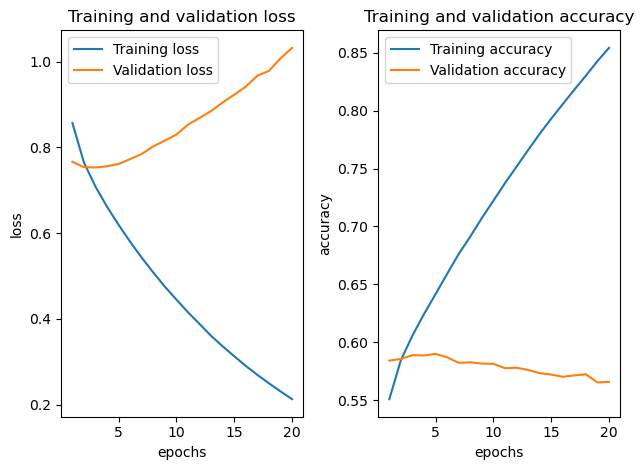

Preprocessor: "bart_seq2_seq_lm_preprocessor_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bart_tokenizer (BartTokenizer)                     │                                              50,265 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bart_seq2_seq_lm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_padding_mask          │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder_token_ids             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_padding_mask          │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_token_ids             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bart_backbone (BartBackbone)  │ [(None, None, 768),       │     139,417,344 │ decoder_padding_mask[0][0… │
│                               │ (None, None, 768)]        │                 │ decoder_token_ids[0][0],   │
│                               │                           │                 │ encoder_padding_mask[0][0… │
│                               │                           │                 │ encoder_token_ids[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 50265)       │      38,603,520 │ bart_backbone[0][0]        │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 139,417,344 (531.83 MB)

 Trainable params: 139,417,344 (531.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


W0000 00:00:1723122732.726651   16856 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5255 - loss: 0.9377

W0000 00:00:1723123046.470644   16856 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



1842/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5256 - loss: 0.9377

W0000 00:00:1723123264.349358   16857 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1723123268.974530   16859 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-08-08 13:21:12.812589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 13:22:04.710132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.43222266>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.42435658>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.39639565>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.16664067>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.16634364>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.15274392>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.33722234>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3345518>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3105506>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 685s 225ms/step - accuracy: 0.5256 - loss: 0.9376 - val_accuracy: 0.5759 - val_loss: 0.7814
Epoch 2/20
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5696 - loss: 0.8045

2024-08-08 13:24:26.137466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 13:24:46.851606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.43401274>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.435518>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.40595815>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.16717024>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.17118134>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.1568645>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3375277>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.34060067>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.31597695>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 163s 87ms/step - accuracy: 0.5696 - loss: 0.8045 - val_accuracy: 0.5846 - val_loss: 0.7637
Epoch 3/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5856 - loss: 0.7615

2024-08-08 13:27:10.897804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 13:27:29.574551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.44260764>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.45627508>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.41884845>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.17940056>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.1878463>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.17026214>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3468154>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3607731>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3292834>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 161s 86ms/step - accuracy: 0.5856 - loss: 0.7615 - val_accuracy: 0.5874 - val_loss: 0.7568
Epoch 4/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5967 - loss: 0.7299

2024-08-08 13:29:49.514997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 13:30:08.479564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.43953255>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.4595242>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.41718107>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.17425305>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.18825543>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.1673446>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.34748968>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.363983>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3299743>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 159s 85ms/step - accuracy: 0.5967 - loss: 0.7299 - val_accuracy: 0.5897 - val_loss: 0.7529
Epoch 5/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6075 - loss: 0.7014

2024-08-08 13:32:28.900776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 13:32:47.911710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.44070393>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.4467291>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.41234672>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.17818703>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.18478696>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.1668375>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.34781116>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.35550237>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.32644644>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 159s 85ms/step - accuracy: 0.6075 - loss: 0.7014 - val_accuracy: 0.5911 - val_loss: 0.7516
Epoch 6/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6189 - loss: 0.6741

2024-08-08 13:35:08.440064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 13:35:30.878856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4588024>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.46389642>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.43153903>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.19553325>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.19809681>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.18276814>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.36477524>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.36870435>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.34268132>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 163s 87ms/step - accuracy: 0.6189 - loss: 0.6741 - val_accuracy: 0.5912 - val_loss: 0.7513
Epoch 7/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6281 - loss: 0.6501

2024-08-08 13:37:57.362542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 13:38:17.380893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.44755137>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.46885186>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.42932814>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18662898>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.19677225>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.17839186>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.35046285>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.36920628>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3367824>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 167s 89ms/step - accuracy: 0.6281 - loss: 0.6501 - val_accuracy: 0.5916 - val_loss: 0.7521
Epoch 8/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6372 - loss: 0.6276

2024-08-08 13:40:38.531171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 13:40:57.623276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.43794948>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.47362605>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.42800787>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18343747>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20195428>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.1798904>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.34582055>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.37724584>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.33861095>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 161s 86ms/step - accuracy: 0.6372 - loss: 0.6276 - val_accuracy: 0.5887 - val_loss: 0.7608
Epoch 9/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6471 - loss: 0.6054

2024-08-08 13:43:19.208084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 13:43:37.979156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.441032>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.46116862>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4238787>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18429366>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.19412774>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.17675449>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.34928823>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3655855>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3356064>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 159s 85ms/step - accuracy: 0.6471 - loss: 0.6054 - val_accuracy: 0.5899 - val_loss: 0.7615
Epoch 10/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6563 - loss: 0.5852

2024-08-08 13:46:02.932193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 13:46:22.966991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.44143733>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.48234132>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4330852>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18521099>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20380688>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.181126>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3480593>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3810946>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.34152907>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 165s 88ms/step - accuracy: 0.6563 - loss: 0.5852 - val_accuracy: 0.5871 - val_loss: 0.7721
Epoch 11/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6653 - loss: 0.5645

2024-08-08 13:48:44.614721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 13:49:03.489988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.44480675>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.46713242>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4286413>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.19219995>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20151626>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.18420371>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3517056>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.37173682>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.33990118>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 161s 86ms/step - accuracy: 0.6653 - loss: 0.5645 - val_accuracy: 0.5880 - val_loss: 0.7765
Epoch 12/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6740 - loss: 0.5454

2024-08-08 13:51:23.032572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 13:51:41.863324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.44879895>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.47086534>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4304447>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18982261>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.2045689>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.18322581>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.35432258>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3756777>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.34108934>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 159s 85ms/step - accuracy: 0.6740 - loss: 0.5454 - val_accuracy: 0.5885 - val_loss: 0.7821
Epoch 13/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6820 - loss: 0.5264

2024-08-08 13:54:08.597513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 13:54:27.763837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.44695243>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.46449906>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.42828107>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18577033>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.19510053>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.17852472>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3524653>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.36822826>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.33863714>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 165s 88ms/step - accuracy: 0.6820 - loss: 0.5264 - val_accuracy: 0.5863 - val_loss: 0.7895
Epoch 14/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6909 - loss: 0.5076

2024-08-08 13:57:03.565236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 13:57:24.023202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.451572>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.48069635>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.43596628>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.19708082>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20980823>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.1890841>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.35788158>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.38251552>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.34567687>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 177s 94ms/step - accuracy: 0.6909 - loss: 0.5076 - val_accuracy: 0.5863 - val_loss: 0.8002
Epoch 15/20
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6990 - loss: 0.4909

2024-08-08 13:59:55.343070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 14:00:15.415013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.44741833>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.484974>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.43874294>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.1918001>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.2080611>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.1863492>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.35447857>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.38610822>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.34792632>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 172s 92ms/step - accuracy: 0.6990 - loss: 0.4909 - val_accuracy: 0.5851 - val_loss: 0.8079
Epoch 16/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7084 - loss: 0.4732

2024-08-08 14:02:45.231977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 14:03:04.532019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.45851448>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.47302866>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.43596268>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.20336865>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20593432>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.19068366>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.36511847>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.376369>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.34690666>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 169s 90ms/step - accuracy: 0.7084 - loss: 0.4732 - val_accuracy: 0.5826 - val_loss: 0.8174
Epoch 17/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7165 - loss: 0.4557

2024-08-08 14:05:27.540723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 14:05:51.416129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.43939257>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.47972375>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4306153>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.1848299>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.2020111>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.18028127>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.34979904>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3814414>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.34248638>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 168s 90ms/step - accuracy: 0.7165 - loss: 0.4557 - val_accuracy: 0.5805 - val_loss: 0.8280
Epoch 18/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7236 - loss: 0.4402

2024-08-08 14:08:16.859126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 14:08:37.469581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.44809654>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.48371297>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.43738872>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.1918995>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20841755>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.1872984>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3534584>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.38277853>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.34517154>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 164s 87ms/step - accuracy: 0.7236 - loss: 0.4402 - val_accuracy: 0.5805 - val_loss: 0.8397
Epoch 19/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7325 - loss: 0.4241

2024-08-08 14:10:59.034929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 14:11:18.495441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4500047>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.48505858>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.43942824>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.19946414>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.21611549>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.19417097>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3557153>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3840279>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3474771>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 162s 86ms/step - accuracy: 0.7325 - loss: 0.4241 - val_accuracy: 0.5812 - val_loss: 0.8481
Epoch 20/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7400 - loss: 0.4083

2024-08-08 14:13:40.800244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 14:14:00.026528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4504134>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.4663264>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.43114877>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.19136064>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20131849>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.18388821>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.35838175>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.37415498>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.34424084>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 161s 86ms/step - accuracy: 0.7400 - loss: 0.4083 - val_accuracy: 0.5791 - val_loss: 0.8519
0.7512573599815369 The best number of epocs for the validation loss is 6
0.5915750861167908 The best number of epocs for the validation accuracy is 7


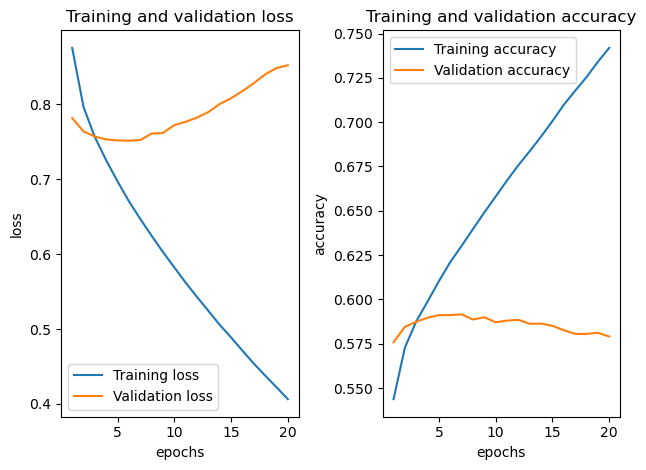

Preprocessor: "bart_seq2_seq_lm_preprocessor_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bart_tokenizer (BartTokenizer)                     │                                              50,265 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bart_seq2_seq_lm_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_padding_mask          │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder_token_ids             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_padding_mask          │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_token_ids             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bart_backbone (BartBackbone)  │ [(None, None, 768),       │     139,417,344 │ decoder_padding_mask[0][0… │
│                               │ (None, None, 768)]        │                 │ decoder_token_ids[0][0],   │
│                               │                           │                 │ encoder_padding_mask[0][0… │
│                               │                           │                 │ encoder_token_ids[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 50265)       │      38,603,520 │ bart_backbone[0][0]        │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 139,417,344 (531.83 MB)

 Trainable params: 139,417,344 (531.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


W0000 00:00:1723126547.566834   16861 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4952 - loss: 1.0598

W0000 00:00:1723126858.661001   16856 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



1842/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.4952 - loss: 1.0598

W0000 00:00:1723127079.330610   16862 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1723127084.055975   16861 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-08-08 14:24:47.954153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 14:25:40.670901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.41791752>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3908447>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.36944577>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.14875391>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.13962603>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.1297835>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.32087716>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.30210775>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.2839765>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 685s 228ms/step - accuracy: 0.4952 - loss: 1.0597 - val_accuracy: 0.5534 - val_loss: 0.8282
Epoch 2/20
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5451 - loss: 0.8688

2024-08-08 14:28:14.000907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 14:28:32.111441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.42756948>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.41499564>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3912398>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.16165695>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.16182952>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.14900061>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.33643368>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3291893>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3086804>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 172s 91ms/step - accuracy: 0.5451 - loss: 0.8688 - val_accuracy: 0.5644 - val_loss: 0.8064
Epoch 3/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5540 - loss: 0.8426

2024-08-08 14:31:07.254929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 14:31:26.093215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4330308>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.41632742>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.39307097>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.15962343>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.15638843>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.14464438>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.33716726>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.32504418>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.30552366>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 174s 93ms/step - accuracy: 0.5540 - loss: 0.8426 - val_accuracy: 0.5700 - val_loss: 0.7944
Epoch 4/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5605 - loss: 0.8255

2024-08-08 14:33:57.021463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 14:34:15.599694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.44268665>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.42132393>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4013494>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.17429194>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.1660634>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.15731376>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.34823817>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.33282977>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.31601635>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 170s 90ms/step - accuracy: 0.5605 - loss: 0.8255 - val_accuracy: 0.5742 - val_loss: 0.7860
Epoch 5/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5667 - loss: 0.8106

2024-08-08 14:36:47.581665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 14:37:05.920887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4458177>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.42647338>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4070541>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.17078806>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.16888773>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.15745376>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3488235>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.33661067>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.31969625>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 170s 91ms/step - accuracy: 0.5667 - loss: 0.8106 - val_accuracy: 0.5768 - val_loss: 0.7798
Epoch 6/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5703 - loss: 0.7994

2024-08-08 14:39:34.357306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 14:39:52.706979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.43662992>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.4319689>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.40392858>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.17100412>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.17135504>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.15822515>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.34417292>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.34323722>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.31927538>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 167s 89ms/step - accuracy: 0.5703 - loss: 0.7994 - val_accuracy: 0.5783 - val_loss: 0.7751
Epoch 7/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5746 - loss: 0.7881

2024-08-08 14:42:21.010340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 14:42:44.398267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4406556>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.4316198>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.40499672>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.17107219>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.17352144>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.15848958>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3469915>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.34336665>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.32026815>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 172s 92ms/step - accuracy: 0.5746 - loss: 0.7881 - val_accuracy: 0.5798 - val_loss: 0.7714
Epoch 8/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5778 - loss: 0.7788

2024-08-08 14:45:14.264288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 14:45:33.004087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4453753>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.43980795>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.412732>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.17578761>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.1815278>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.16467197>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.34871218>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3482497>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.32450262>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 168s 90ms/step - accuracy: 0.5778 - loss: 0.7788 - val_accuracy: 0.5808 - val_loss: 0.7689
Epoch 9/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5815 - loss: 0.7698

2024-08-08 14:48:02.347020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 14:48:21.670691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.44164193>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.44475752>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4146651>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.1737833>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.17875992>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.1644013>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.34522822>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.35023662>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.32514915>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 169s 90ms/step - accuracy: 0.5815 - loss: 0.7698 - val_accuracy: 0.5832 - val_loss: 0.7656
Epoch 10/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5854 - loss: 0.7604

2024-08-08 14:50:56.882326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 14:51:16.019417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4575924>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.43926734>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4186241>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18367189>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.1773209>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.16777973>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.35891545>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.34810546>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.32968462>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 175s 93ms/step - accuracy: 0.5854 - loss: 0.7603 - val_accuracy: 0.5851 - val_loss: 0.7627
Epoch 11/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5879 - loss: 0.7542

2024-08-08 14:53:52.259239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 14:54:11.657429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.44573218>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.4359546>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4127019>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18089122>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.18035346>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.16774179>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.34881562>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3440367>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3238558>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 175s 93ms/step - accuracy: 0.5879 - loss: 0.7542 - val_accuracy: 0.5859 - val_loss: 0.7612
Epoch 12/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5905 - loss: 0.7459

2024-08-08 14:56:51.148120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 14:57:11.128107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4493873>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.43980938>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4139019>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18010135>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.17637236>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.16475292>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.35235047>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3464105>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.32473665>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 179s 96ms/step - accuracy: 0.5905 - loss: 0.7459 - val_accuracy: 0.5861 - val_loss: 0.7597
Epoch 13/20
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5944 - loss: 0.7370

2024-08-08 14:59:46.377580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 15:00:05.536264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.45611215>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.4468508>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4221129>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18798019>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.1848344>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.1730464>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.36269265>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3570571>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.33642548>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 175s 93ms/step - accuracy: 0.5944 - loss: 0.7370 - val_accuracy: 0.5868 - val_loss: 0.7579
Epoch 14/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5972 - loss: 0.7311

2024-08-08 15:02:39.701701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 15:02:58.555595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.45362756>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.44166845>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4180188>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18184929>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.1841556>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.16980223>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.35693532>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3517372>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3304634>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 173s 92ms/step - accuracy: 0.5972 - loss: 0.7311 - val_accuracy: 0.5874 - val_loss: 0.7563
Epoch 15/20
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5986 - loss: 0.7253

2024-08-08 15:05:28.262599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 15:05:47.963352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.46175587>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.44063202>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.42139265>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18368043>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.18170793>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.16991416>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.36257687>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.35021752>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.33277932>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 169s 90ms/step - accuracy: 0.5986 - loss: 0.7253 - val_accuracy: 0.5881 - val_loss: 0.7557
Epoch 16/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6019 - loss: 0.7183

2024-08-08 15:08:10.154937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 15:08:28.534938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.45633844>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.45157945>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.42642918>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18421026>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.18367101>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.17163925>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.36056477>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.35837054>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.3372834>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 160s 86ms/step - accuracy: 0.6019 - loss: 0.7183 - val_accuracy: 0.5884 - val_loss: 0.7546
Epoch 17/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6038 - loss: 0.7118

2024-08-08 15:10:54.901009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 15:11:14.722303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.46064687>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.45294297>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.42669365>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.19326055>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.19151129>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.17826505>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.36705402>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3609194>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.33954948>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 168s 90ms/step - accuracy: 0.6038 - loss: 0.7118 - val_accuracy: 0.5889 - val_loss: 0.7541
Epoch 18/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6070 - loss: 0.7052

2024-08-08 15:13:38.281865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 15:13:57.010148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4562745>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.44752476>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.42258444>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.1888778>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.18883617>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.17599723>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.35941365>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.35421488>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.33347613>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 161s 86ms/step - accuracy: 0.6070 - loss: 0.7052 - val_accuracy: 0.5896 - val_loss: 0.7539
Epoch 19/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6084 - loss: 0.6994

2024-08-08 15:16:19.960426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 15:16:38.224661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4577244>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.4425816>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4210778>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18900166>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.18431038>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.17386019>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.36286753>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.35184857>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.33393154>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 162s 86ms/step - accuracy: 0.6084 - loss: 0.6994 - val_accuracy: 0.5895 - val_loss: 0.7534
Epoch 20/20
1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6105 - loss: 0.6941

2024-08-08 15:19:01.844938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-08 15:19:20.337782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.45091185>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.45296562>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.42245415>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18317097>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.18714455>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.1724192>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3568068>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.36025295>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.33491778>}
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 162s 87ms/step - accuracy: 0.6105 - loss: 0.6941 - val_accuracy: 0.5891 - val_loss: 0.7536
0.7534153461456299 The best number of epocs for the validation loss is 19
0.5895649194717407 The best number of epocs for the validation accuracy is 18


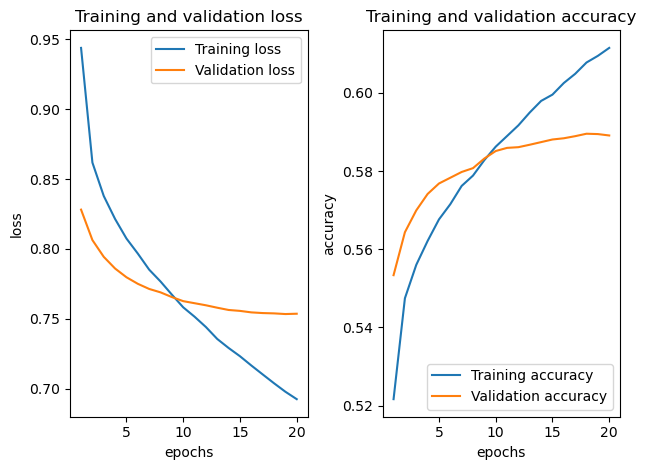

In [ ]:
for learning_rate in [1e-5, 5e-6, 1e-6]:
    bart_lm, filepath, history = build_bart_model(
        training_data=train_ds,
        validation_data=validation_ds,
        learning_rate=learning_rate,
        epochs=20,
        is_saved=False,
    )
    plot(history=history, keys=["loss", "accuracy"])


### Note (Experiment Date: 2024-08-02 13:52:00~)

- BART with pretrained model

#### Result

- Unexpectedly, `bart_base_en` model marked slightly better ROUGE score.

_ | ROUGE-1 | ROUGE-2 | ROUGE-L
--- | --- | --- | ---
bart_large_en | 39.6 | 16.2 | 31.4
bart_large_en_cnn | 41.2 | 16.7 | 33.1
bart_base_en | 42.1 | 18.1 | 34.3

#### Next

- Calculate each ROUGE score for every epoch because it is not always that the highest accuracy or the least loss makes the best ROUGE.
- Parameter-tuning of optimizer, even though it seems hard to improve the ROUGE score because training did not improve the validation loss and accuracy.
- Bare Transformer model with the best number of epochs.

#### bart_large_en

In [ ]:
bart_lm, filepath, history = build_bart_model(
    training_data=train_ds,
    validation_data=validation_ds,
    preset_name="bart_large_en",
    is_saved=False,
)
plot(history=history, keys=["loss", "accuracy"])

best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_accuracy"]))
best_epoch = best_epoch + 1
print("The best epoch is", best_epoch)
bart_lm, filepath, _ = build_bart_model(
    training_data=train_ds.concatenate(validation_ds),
    validation_data=None,
    epochs=best_epoch,
    preset_name="bart_large_en",
    verbose=0,
    is_saved=False,
)

In [ ]:
dialogue, y_true, y_pred = generate_prediction_result(
    bart_lm=bart_lm,
    ds=test_ds.map(format_dataset_bart_seq2seq),
)
display_sampled_summary(
    x=dialogue,
    y_true=y_true,
    y_pred=y_pred
)

Dialogue: b"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him \xf0\x9f\x99\x82\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"
Generated Summary: Betty's number is not in Amanda's possession and Hannah will ask Larry if she could get it for Betty. Hannah is not sure about Betty. Hannah will let Amanda know when she can talk with her. Hannah will text him about the situation.
Ground Truth Summary: b"Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry."
Dialogue: b"Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric: I know! And shows how Americans see Russian ;)\r\nRob: And it's really funny!\r\nEric: I know! I especially like the train part!\r\

In [ ]:
calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)

({'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4121847>,
  'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.44109234>,
  'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.39567354>},
 {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.1710483>,
  'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.18096353>,
  'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.16223642>},
 {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.32824823>,
  'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.35013813>,
  'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.31380486>})

#### bart_large_en_cnn

Preprocessor: "bart_seq2_seq_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bart_tokenizer (BartTokenizer)                     │                                              50,265 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bart_seq2_seq_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_padding_mask          │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder_token_ids             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_padding_mask          │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_token_ids             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bart_backbone (BartBackbone)  │ [(None, None, 1024),      │     406,286,336 │ decoder_padding_mask[0][0… │
│                               │ (None, None, 1024)]       │                 │ decoder_token_ids[0][0],   │
│                               │                           │                 │ encoder_padding_mask[0][0… │
│                               │                           │                 │ encoder_token_ids[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 50264)       │      51,470,336 │ bart_backbone[0][0]        │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 406,286,336 (1.51 GB)

 Trainable params: 406,286,336 (1.51 GB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


I0000 00:00:1723039751.564694   17621 service.cc:145] XLA service 0x7feaac012e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723039751.564836   17621 service.cc:153]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-08-07 14:09:14.493745: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1723039756.114154   17621 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-08-07 14:09:29.662078: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1723039899.313737   19539 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_739', 452 bytes spill stores, 700 bytes spill loads

I0000 00:00:1723

1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5682 - loss: 0.8171

W0000 00:00:1723040405.032939   17621 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723040556.522585   27612 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_198', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1723040557.146435   27613 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_810', 452 bytes spill stores, 700 bytes spill loads

I0000 00:00:1723040558.922157   27617 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_314', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1723040562.586773   27617 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_763', 452 bytes spill stores, 700 bytes spill loads

I0000 00:00:1723040562.883024   27616 


1842/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.5682 - loss: 0.8171

W0000 00:00:1723040866.679881   17617 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1723040874.151060   17621 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723040877.936740     803 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_278', 452 bytes spill stores, 700 bytes spill loads

I0000 00:00:1723040880.270306     801 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_231', 452 bytes spill stores, 700 bytes spill loads

I0000 00:00:1723040885.594276     798 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_192', 1884 bytes spill stores, 1880 bytes spill loads



1842/1842 ━━━━━━━━━━━━━━━━━━━━ 1253s 387ms/step - accuracy: 0.5682 - loss: 0.8171 - val_accuracy: 0.5757 - val_loss: 0.7771
Epoch 2/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 227s 122ms/step - accuracy: 0.6421 - loss: 0.6159 - val_accuracy: 0.5651 - val_loss: 0.7857
Epoch 3/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 227s 122ms/step - accuracy: 0.7067 - loss: 0.4662 - val_accuracy: 0.5645 - val_loss: 0.8564
Epoch 4/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 232s 124ms/step - accuracy: 0.7625 - loss: 0.3580 - val_accuracy: 0.5440 - val_loss: 0.9714
Epoch 5/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 229s 123ms/step - accuracy: 0.8064 - loss: 0.2773 - val_accuracy: 0.5487 - val_loss: 1.0180
0.7771388292312622 The best number of epocs for the validation loss is 1
0.5757169723510742 The best number of epocs for the validation accuracy is 1


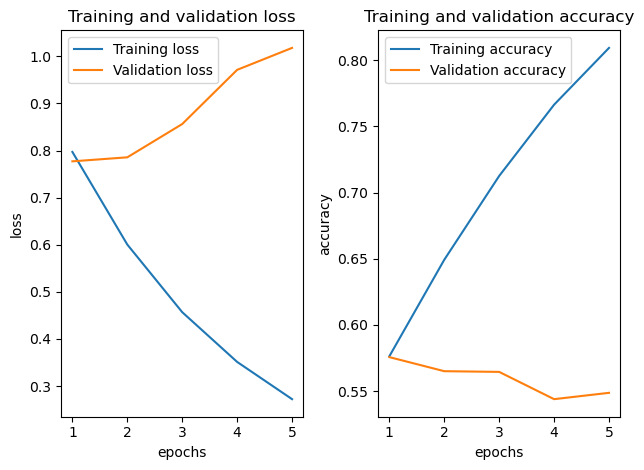

The best epoch is 1


W0000 00:00:1723041939.068717   17620 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1723042571.643959   17620 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723042718.712457   22462 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_198', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1723042720.306850   22456 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_810', 452 bytes spill stores, 700 bytes spill loads

I0000 00:00:1723042721.355270   22462 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_763', 452 bytes spill stores, 700 bytes spill loads

I0000 00:00:1723042721.829958   22457 a

In [ ]:
bart_lm, filepath, history = build_bart_model(
    training_data=train_ds,
    validation_data=validation_ds,
    preset_name="bart_large_en_cnn",
    is_saved=False,
)
plot(history=history, keys=["loss", "accuracy"])

best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_accuracy"]))
best_epoch = best_epoch + 1
print("The best epoch is", best_epoch)
bart_lm, filepath, _ = build_bart_model(
    training_data=train_ds.concatenate(validation_ds),
    validation_data=None,
    epochs=best_epoch,
    preset_name="bart_large_en_cnn",
    verbose=0,
    is_saved=False,
)

In [ ]:
dialogue, y_true, y_pred = generate_prediction_result(
    bart_lm=bart_lm,
    ds=test_ds.map(format_dataset_bart_seq2seq),
)
display_sampled_summary(
    x=dialogue,
    y_true=y_true,
    y_pred=y_pred
)

Dialogue: b"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him \xf0\x9f\x99\x82\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"
Generated Summary: Hannah is looking for Betty's number. Amanda will text Larry. Hannah has a cold.
Ground Truth Summary: b"Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry."
Dialogue: b"Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric: I know! And shows how Americans see Russian ;)\r\nRob: And it's really funny!\r\nEric: I know! I especially like the train part!\r\nRob: Hahaha! No one talks to the machine like that!\r\nEric: Is this his only stand-up?\r\nRob: Idk. I'll check.\r\nEric: Sure.\r\nRob: Turns out no! 

In [ ]:
calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)

({'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.45377052>,
  'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.43094596>,
  'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.41213316>},
 {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18619569>,
  'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.175663>,
  'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.16733189>},
 {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.36458507>,
  'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3471443>,
  'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.33139962>})

#### bart_base_en

100%|██████████| 141/141 [00:00<00:00, 267kB/s]


100%|██████████| 448/448 [00:00<00:00, 1.87MB/s]


100%|██████████| 0.99M/0.99M [00:01<00:00, 884kB/s]


100%|██████████| 446k/446k [00:00<00:00, 491kB/s]


100%|██████████| 483/483 [00:00<00:00, 948kB/s]


100%|██████████| 532M/532M [00:25<00:00, 22.0MB/s] 


Preprocessor: "bart_seq2_seq_lm_preprocessor_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bart_tokenizer (BartTokenizer)                     │                                              50,265 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bart_seq2_seq_lm_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_padding_mask          │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder_token_ids             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_padding_mask          │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_token_ids             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bart_backbone (BartBackbone)  │ [(None, None, 768),       │     139,417,344 │ decoder_padding_mask[0][0… │
│                               │ (None, None, 768)]        │                 │ decoder_token_ids[0][0],   │
│                               │                           │                 │ encoder_padding_mask[0][0… │
│                               │                           │                 │ encoder_token_ids[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 50265)       │      38,603,520 │ bart_backbone[0][0]        │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 139,417,344 (531.83 MB)

 Trainable params: 139,417,344 (531.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


W0000 00:00:1723043218.172744   17618 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723043292.824088   30899 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1723043300.536645   30900 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 1884 bytes spill stores, 1880 bytes spill loads

I0000 00:00:1723043396.629483   17618 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_227__3', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_30', 4 bytes spill stores, 4 bytes spill loads



1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5366 - loss: 0.9073

W0000 00:00:1723043496.547310   17621 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723043578.554509    1931 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1723043586.128558    1928 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 1884 bytes spill stores, 1880 bytes spill loads

I0000 00:00:1723043685.974172   17621 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_636__4', 156 bytes spill stores, 156 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_256__3', 16 bytes spill stores, 16 bytes spill loads




1842/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5366 - loss: 0.9073

W0000 00:00:1723043697.963411   17620 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1723043702.376123   17623 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723043708.325045    4503 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1723043712.422581    4505 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 1884 bytes spill stores, 1880 bytes spill loads



1842/1842 ━━━━━━━━━━━━━━━━━━━━ 560s 174ms/step - accuracy: 0.5366 - loss: 0.9073 - val_accuracy: 0.5760 - val_loss: 0.7845
Epoch 2/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 110s 58ms/step - accuracy: 0.6037 - loss: 0.7151 - val_accuracy: 0.5764 - val_loss: 0.7936
Epoch 3/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 108s 58ms/step - accuracy: 0.6543 - loss: 0.5870 - val_accuracy: 0.5759 - val_loss: 0.8245
Epoch 4/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 107s 57ms/step - accuracy: 0.7022 - loss: 0.4822 - val_accuracy: 0.5661 - val_loss: 0.8723
Epoch 5/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 107s 57ms/step - accuracy: 0.7452 - loss: 0.3946 - val_accuracy: 0.5620 - val_loss: 0.9287
0.7845414876937866 The best number of epocs for the validation loss is 1
0.5764316916465759 The best number of epocs for the validation accuracy is 2


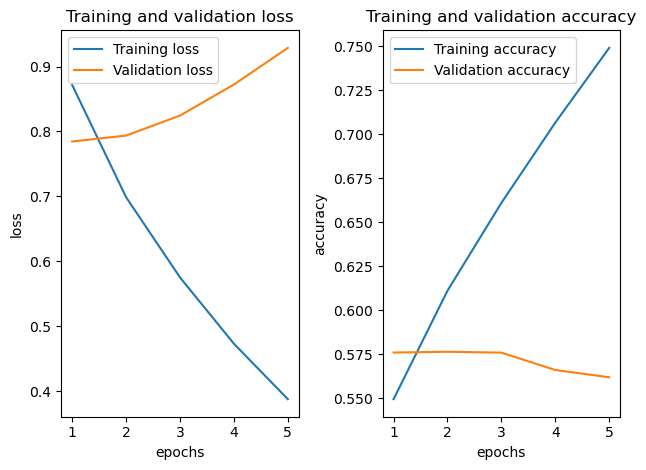

The best epoch is 2


W0000 00:00:1723044224.952225   17618 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1723044482.532171   17618 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723044558.035285   14356 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1723044565.304360   14359 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 1884 bytes spill stores, 1880 bytes spill loads

I0000 00:00:1723044666.473497   17618 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_244__3', 20 bytes spill stores, 20 bytes spill loads



In [ ]:
bart_lm, filepath, history = build_bart_model(
    training_data=train_ds,
    validation_data=validation_ds,
    is_saved=False,
)
plot(history=history, keys=["loss", "accuracy"])

best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_accuracy"]))
best_epoch = best_epoch + 1
print("The best epoch is", best_epoch)
bart_lm, filepath, _ = build_bart_model(
    training_data=train_ds.concatenate(validation_ds),
    validation_data=None,
    epochs=best_epoch,
    verbose=0,
    is_saved=False,
)

In [ ]:
dialogue, y_true, y_pred = generate_prediction_result(
    bart_lm=bart_lm,
    ds=test_ds.map(format_dataset_bart_seq2seq),
)
display_sampled_summary(
    x=dialogue,
    y_true=y_true,
    y_pred=y_pred
)

Dialogue: b"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him \xf0\x9f\x99\x82\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"
Generated Summary: Hannah can't find Betty's number, because she called Larry last time they were at the park together. Amanda suggests to text Larry instead of using Facebook.
Ground Truth Summary: b"Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry."
Dialogue: b"Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric: I know! And shows how Americans see Russian ;)\r\nRob: And it's really funny!\r\nEric: I know! I especially like the train part!\r\nRob: Hahaha! No one talks to the machine like that!\r\nEric: Is this his 

In [ ]:
calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)

({'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.44864184>,
  'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.44959518>,
  'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.42114675>},
 {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.19555798>,
  'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.19434093>,
  'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.18135415>},
 {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.36647415>,
  'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.36553767>,
  'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.34278908>})